## Baseline соревнования 11.30557.
### Мой результат - 10.89438. И 16е место из 22х получивших результат лучше бэйзлайна на момент получения результата.

<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам
*Этот Ноутбук является Примером/Шаблоном (Baseline) к этому соревнованию и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.


> **baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline является хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

Помним, что по условию соревнования, нам нужно самостоятельно собрать обучающий датасет. В этом ноутбуке мы не будем рассматривать сбор данных. Предположим, что мы уже все собрали и просто подключили свой датасет через "Add Data", чтобы приступить к самому ML.

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# import pandas_profiling
import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
import math
import re
import codecs
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from itertools import combinations
from scipy.stats import ttest_ind
from sklearn.feature_extraction.text import CountVectorizer
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [5]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
Numpy        : 1.19.1


In [6]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [7]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
# RANDOM_SEED = 15


# Setup

In [8]:
VERSION    = 69
DIR_TRAIN  = 'D:/MY_DOC/Notebooks/DataScience-Practice/Profitable choosing car/train_data/'
DIR_TEST   = 'D:/MY_DOC/Notebooks/DataScience-Practice/Profitable choosing car/test_data/'
VAL_SIZE   = 0.33   # 33%
N_FOLDS    = 5

# CATBOOST
# ITERATIONS = 30000
# LR         = 0.005
ITERATIONS = 6000
LR         = 0.1
THRESHOLD = 3

# Data

In [9]:
#!ls ../input/

In [10]:
train = pd.read_csv(DIR_TRAIN+'BMW_ready_10092020.csv', sep =';') # мой подготовленный датасет для обучения модели
# train = pd.read_csv(DIR_TRAIN+'all_cars_09092020.csv', sep =';')
train = train.drop(['Unnamed: 0'], axis = 1)
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

## EDA

In [8]:
train.shape

(78326, 25)

In [9]:
train.head(1)

,index,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,Цена,id
0,0,Седан,BMW,серый,бензин,1968.0,2.5 MT (150 л.с.),4.0,1969,SEDAN MECHANICAL 2.5,механическая,2.5 LTR,150 N12,В продаже оригинальная BMW 2500 Родной двигат...,200000.0,None,задний,Левый,Не требует ремонта,2,Оригинал,Растаможен,9 лет и 7 месяцев,460000,0


In [10]:
train = train.drop(['index'], axis = 1)
# train = train.drop_duplicates(keep = 'first')
# train = train.reset_index()
# train = train.drop(['index'], axis = 1)
# train['id'] = train.index 

In [11]:
#Приводим в порядок имена столбцов
columns_dict = {
        'bodyType':'body_type',
        'fuelType':'fuel_type',
        'modelDate':'model_date',
        'name':'engine_description',
        'numberOfDoors':'number_of_doors',
        'productionDate':'production_date',
        'vehicleConfiguration':'vehicle_configuration',
        'vehicleTransmission':'vehicle_transmission',
        'engineDisplacement':'engine_displacement',
        'enginePower':'engine_power',
        'Комплектация':'complectation',
        'Привод':'drive',
        'Руль':'stear',
        'Состояние': 'conditions',
        'Владельцы':'owners',
        'ПТС':'pts',
        'Таможня':'customs',
        'Владение':'ownership', 
        'Цена':'price'
    }
train.rename(columns = columns_dict, inplace=True)
test.rename(columns = columns_dict, inplace=True)

In [12]:
train.describe(include = 'all')

,body_type,brand,color,fuel_type,model_date,engine_description,number_of_doors,production_date,vehicle_configuration,vehicle_transmission,engine_displacement,engine_power,description,mileage,complectation,drive,stear,conditions,owners,pts,customs,ownership,price,id
count,78326,78326,78326,78326,78326.000000,78326,78326.000000,78326.000000,78326,78326,78326,78326,78326,78326.000000,78326,78326,78326,78326,78326,78326,78326,78326,7.832600e+04,78326.000000
unique,36,1,16,4,NaN,704,NaN,NaN,167,3,31,95,40166,NaN,458,3,2,1,4,3,1,259,NaN,NaN
top,седан,BMW,чёрный,бензин,NaN,30d 3.0d AT (249 л.с.) 4WD,NaN,NaN,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,2.0 LTR,184 N12,None,NaN,None,полный,Левый,Не требует ремонта,3,Оригинал,Растаможен,None,NaN,NaN
freq,16818,78326,30844,51352,NaN,2946,NaN,NaN,16855,69651,28974,8643,2362,NaN,47052,44455,78277,78326,36413,65614,78326,52275,NaN,NaN
mean,NaN,NaN,NaN,NaN,2008.884113,NaN,4.357468,2010.925887,NaN,NaN,NaN,NaN,NaN,136819.815885,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.920763e+06,39162.500000
std,NaN,NaN,NaN,NaN,8.002039,NaN,0.745633,7.660472,NaN,NaN,NaN,NaN,NaN,116282.527589,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.001683e+06,22610.912929
min,NaN,NaN,NaN,NaN,1937.000000,NaN,2.000000,1948.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000e+04,0.000000
25%,NaN,NaN,NaN,NaN,2005.000000,NaN,4.000000,2007.000000,NaN,NaN,NaN,NaN,NaN,34000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.100000e+05,19581.250000
50%,NaN,NaN,NaN,NaN,2010.000000,NaN,4.000000,2012.000000,NaN,NaN,NaN,NaN,NaN,125000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.190000e+06,39162.500000
75%,NaN,NaN,NaN,NaN,2015.000000,NaN,5.000000,2017.000000,NaN,NaN,NaN,NaN,NaN,203000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.694486e+06,58743.750000


In [13]:
#Видно, что есть машина с годом производства 1937. Явный выброс, удалим его
train = train.query("model_date not in [1937]")

In [14]:
#Переводим все значения признака body_type нижний регистр, как в тесте
train['body_type'] = train['body_type'].apply(lambda x: x.lower())

In [15]:
#Вычисляем средний срок владения автомобилем в месяцах. Понадобится для замещения пропусков  в данных. 
pattern = re.compile('\d+')
train_with_ownership = train.query("ownership not in ['None']")
train_with_ownership.reset_index(inplace = True)
train_with_ownership = train_with_ownership.drop(['index'], axis = 1)
own_list = []
#Составляем список из всех значение срока владения в месяцах. Регуляркой вытаскиваем из строки числа. Первое число - годы владения, 
#второе - месяцы. Приводим все к "месячному" формату.  
for index,row in train_with_ownership.iterrows():
    own_list.append(int(pattern.findall(row['ownership'])[0])*12 + int(pattern.findall(row['ownership'])[1]))
own_train_series = pd.Series(own_list)
train_with_ownership['own_list'] = pd.Series(own_list) ###Убрать после оценки выбросов по владению
#Смотрим описание. Средним значением владения потому заполним пропуски в значениях признака
ownership_variable = own_train_series.median()
print(ownership_variable)

35.0


In [16]:
#Функция для поиска выбросов на основании межквартильного расстояния
def outlier_detect_IQR(data,col,threshold):    
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    Lower_fence = data[col].quantile(0.25) - (IQR * threshold)
    Upper_fence = data[col].quantile(0.75) + (IQR * threshold)
    para = (Upper_fence, Lower_fence)
    tmp = pd.concat([data[col]>Upper_fence,data[col]<Lower_fence],axis=1)
    outlier_index = tmp.any(axis=1)
    try:
        print('Количество выбросов в данных:',outlier_index.value_counts()[1])
        print('Доля выбросов:',outlier_index.value_counts()[1]/len(outlier_index))
        return outlier_index, para
    except Exception as ex:
        print(ex, 'Выбросов нет)')

In [17]:
#Функция для замены выбросов на усредненные значения. 
def impute_outlier_with_avg(data,col,outlier_index,strategy):
    if strategy=='mean':
        data.loc[outlier_index,col] = data[col].mean()
    elif strategy=='median':
        data.loc[outlier_index,col] = data[col].median()
    elif strategy=='mode':
        data.loc[outlier_index,col] = data[col].mode()[0]           
    return data

In [18]:
#Смотрим выбросы по пробегу (mileage)
index,para = outlier_detect_IQR(data=train,col='mileage',threshold=THRESHOLD)
print('Верхняя граница:',para[0],'\nНижняя граница:',para[1])

Количество выбросов в данных: 59
Доля выбросов: 0.0007532716246409192
Верхняя граница: 710000.0 
Нижняя граница: -473000.0


In [19]:
#Заменяем выбросы по пробегу на усредненные значения
train = impute_outlier_with_avg(data=train,col='mileage', outlier_index=index, strategy='mean')

In [20]:
#Определяем средние значения пробега для автомобилей у которых год выпуска старше 2019. Для замены нулевых значений пробега. 
#Берем до 2019 т.к. за 2019-2020 есть новые машины без пробега
tmp_mileage = train[train['production_date'] <2019]
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
imputer.fit(tmp_mileage[['mileage']])
mileage_variable = round(imputer.statistics_[0],2)
print(mileage_variable)

172549.35


In [21]:
#Заменяем нулевые значения пробега на усредненные
for index, row in train.iterrows():
    if row['production_date'] < 2019 and row['mileage'] == 0:
        train['mileage'][index] = mileage_variable

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [22]:
#Исключаем позиции с отсутствующими ценами, если вдруг такие есть в датасете (смотрим ячейку с describe)
train = train.query("price not in ['None']")

In [23]:
#Уменьшаем размерность признака body_type, приводим разномастные названия типов кузовов к тем, которые есть в тесте
def body_type_correction(item):
    if 'лифтбек' in item:
        return('лифтбек')
    elif 'родстер' in item:
        return('родстер')
    elif 'компактвэн' in item:
        return('компактвэн')
    elif 'купе' in item:
        return('купе')
    else:
        return(item)
train['body_type'] = train['body_type'].apply(body_type_correction)

In [24]:
#Дополнительно приводим диапазон дат в соответствие с тестом
train = train.query("model_date >= [1975]")
train = train.query("model_date < [2020]")
train = train.query("production_date < [2020]")

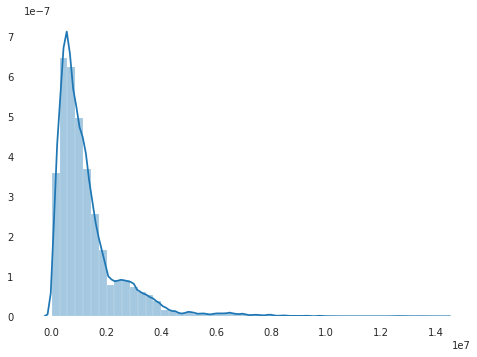

In [25]:
sns.distplot(train.price.values)

In [26]:
#Поработаем над стоимостью авто в трейне.
def price_transform(item):
    #Т.к. тестовый датасет для соревнования собирался в феврале, а сейчас сентябрь, был скачок доллара, изменения на рынке из-за карантина и т.д., 
    #то надо откорректировать цены авто на уровень феральских 
    item = item-(item*0.09)
    #А теперь прологарифмируем цены. Чтобы распределение было ближе к нормальному. 
    return np.log1p(item)
train['price'] = train['price'].apply(price_transform)

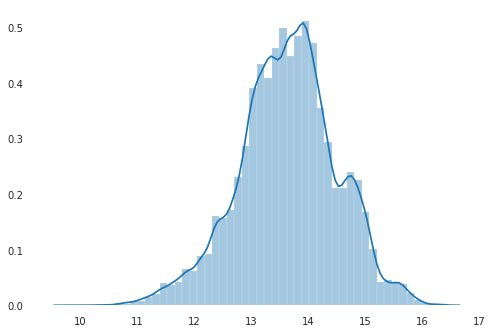

In [27]:
sns.distplot(train.price.values)

In [28]:
train.head(1)

,body_type,brand,color,fuel_type,model_date,engine_description,number_of_doors,production_date,vehicle_configuration,vehicle_transmission,engine_displacement,engine_power,description,mileage,complectation,drive,stear,conditions,owners,pts,customs,ownership,price,id
5,седан,BMW,коричневый,бензин,1976.0,518 1.8 MT (90 л.с.),4.0,1976,SEDAN MECHANICAL 1.8,механическая,1.8 LTR,90 N12,Был заменен двс родной номерной блок в наличи...,320000.0,None,задний,Левый,Не требует ремонта,3,Дубликат,Растаможен,13 лет и 4 месяца,11.641767,5


## Data Preprocessing

In [29]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    
    df_output = df_input.copy()
    
    # ################### Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['customs', 'conditions', 'brand', 'stear', 'vehicle_configuration','id'], axis=1, inplace=True,)
#     df_output.drop(['customs', 'conditions','stear', 'vehicle_configuration','id'], axis=1, inplace=True,)

    
    # ################### Feature Engineering ####################################################
    # тут ваш код на генерацию новых фитчей
    

    #1) ПРИЗНАКИ НЕ ПРИГОДИЛИСЬ. ПОСЛЕ ПРОГОНА МОДЕЛИ СТАЛО ВИДНО, ЧТО У НИХ НИЗКАЯ ВАЖНОСТЬ ДЯЛ МОДЕЛИ. 
    # Создаем новые признаки из текста в признаке complectation и добавляем новые столбцы под значения признаков в датасет. 
    # Делаем это вручную. Вариант с get_dummies тут не проходит, т.к. набор признаков получается разный для трейна и для теста
#     with open("../input/cars-features-cropped/all_features_eng_cropped.txt", 'r', encoding='utf8') as f_eng: #Загружаем файл с названиями англоязычных признаков
#         complectation_list_eng = [line.strip() for line in f_eng] #Преобразуем файл в список
#     tmp = pd.DataFrame(columns = complectation_list_eng)
#     df_output = pd.concat([df_output, tmp])
#     df_output[complectation_list_eng] = df_output[complectation_list_eng].fillna(0)
    
    
#     with open("../input/cars-features-cropped/all_features_rus_cropped.txt", 'r', encoding='utf8') as f_rus: #Загружаем файл с названиями русскоязычных признаков
#         complectation_list_rus = [line.strip() for line in f_rus]

#     #   Парсим признак "Комплектация", вытягиваем из него данные. Смотрим, если значение из списка complectation_list_eng/complectation_list_rus, 
#     # то и делаем из него новый признак. 
#     for index, row in df_output.iterrows():
#         for i in range(int(0), int(len(complectation_list_eng))):
#             if str(complectation_list_eng[i]) in str(row['complectation']):
#                 df_output[complectation_list_eng[i]][index] = 1
#         for i in range(int(0), int(len(complectation_list_eng))):
#             if str(complectation_list_rus[i]) in str(row['complectation']):
#                 df_output[complectation_list_eng[i]][index] = 1
    
    #2) Преобразуем description и числовой вид (вместо описания ставим длину описания в символах)
    df_output['description'] = df_output['description'].fillna('[]')
    def feature_len(item):
        return len(item)
    df_output['description_len'] = df_output['description'].apply(feature_len)
    
    
    #3) Преобразуем признак engineDisplacement в цифровой формат. Либо ставим объем ДВС числом, либо, если это не ДВС - ставим 0. 
    def engine_correct (item):
        item = item[:-4]
        non_DVG = ['уни', 'Ele', 'undefined']
        if item in non_DVG:
            return(0)
        else:
            return(float(item))
    df_output['engine_displacement'] = df_output['engine_displacement'].apply(engine_correct)

    #4) Преобразуем признак engine_power в цифровой формат. Отбрасываем ненужную текстовую часть.      
    df_output['engine_power'] = df_output['engine_power'].fillna(0)
    def enginePower_correction (item):
        if item == 0 or item == 'None':
            return(0)
        else:
            return(float(item[:-4]))
    df_output['engine_power'] = df_output['engine_power'].apply(enginePower_correction)
    
    #5) Преобразуем признак owners в цифровой формат. Если в значении признака нет данных, то ставим "2", это среднее количество владельцев. 
    def owner_correction (item):
        if item == 'None':
            return (2)
        else:
            return(int(item[0]))
    df_output['owners'] = df_output['owners'].apply(owner_correction)

    #6)Оцифровываем значения в столбце ownership - преобразовываем в срок владения в месяцах
    df_output['ownership'] = df_output['ownership'].fillna(ownership_variable) #Заполняем наны медианным значением владения по месяцам в тренировочном датасете, 
                                                                               #его посчитал выше 
    pattern = re.compile('\d+')
    def ownership_correction(item):
        if item == ownership_variable:
            return(item)            
        elif item == 'None':
            return(ownership_variable)   
        elif (len(pattern.findall(item)) == 1) and (('меся') in item):
            return(int(pattern.findall(item)[0]))
        elif (len(pattern.findall(item)) == 1) and ((('год') in item) or (('лет') in item)):                                            
             return(int(pattern.findall(item)[0])*12)
        else:
            return(int(pattern.findall(item)[0])*12 + int(pattern.findall(item)[1]))
    df_output['ownership'] = df_output['ownership'].apply(ownership_correction)

    #7) Оставляем в engine_description только код модели. Остальная информация из этого признака есть в других признаках.     
    def model_number(item):
        space_number = item.find(' ')
        if ('xDrive' in item) and ('xDrive' in item[:space_number]):
            return(str(item[:space_number]))
        elif ('xDrive' in item) and ('xDrive' not in item[:space_number]):
            return(str(item[:space_number]+' '+'xDrive'))
        else:
            return(item[:space_number])
    df_output['engine_description'] = df_output['engine_description'].apply(model_number)
    
    #8) Добавляем признак "Возраст автомобиля" (auto_age)
    now = datetime.datetime.now()
    df_output['auto_age'] = 0
    def auto_age_calc(item):
        return int(now.year - item)
    df_output['auto_age'] = df_output['production_date'].apply(auto_age_calc)
    
    #9) Добавляем признак "пробег в год" (mileage_per_year)
    df_output['mileage_per_year'] = 0
    for index,row in df_output.iterrows():
        if (row['auto_age'] == 0)  or (row['mileage'] == 0):
            df_output['mileage_per_year'][index] = 0
        else:
            df_output['mileage_per_year'][index] = row['mileage']/row['auto_age']
    #10) Добавляем признак "model_age" (указывается в месяцах) 
    df_output['model_age'] = 0
    for index, row in df_output.iterrows():
        tmp = (row['production_date'] - row['model_date'])*12
        if tmp > 0:
            df_output['model_age'][index] = tmp
        else:
            df_output['model_age'][index] = abs(tmp)
    #Есть три авто у который дата модели новее даты выпуска. Это ошибка данных, удаляем эти строки
#     df_output = df_output.query("model_age not in [-1]")
       
    # ################### fix ############################################################## 
    for feature in ['model_date', 'number_of_doors','engine_power', 'description_len', 'mileage', 'production_date','engine_displacement','owners','auto_age','mileage_per_year']:
        df_output[feature]=df_output[feature].astype('float32')
    # ################### Clean #################################################### 
    # убираем признаки которые "оцифровали", 

    df_output.drop(['complectation','ownership','description'], axis=1, inplace=True,)
#     df_output.drop(['description'], axis=1, inplace=True,)
    
    return df_output

In [30]:
train_preproc = preproc_data(train)
X_sub = preproc_data(test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:121: SettingWithCopyWarning: 
A value is trying 

In [31]:
train_preproc.head(1)

,body_type,color,fuel_type,model_date,engine_description,number_of_doors,production_date,vehicle_transmission,engine_displacement,engine_power,mileage,drive,owners,pts,price,description_len,auto_age,mileage_per_year,model_age
5,седан,коричневый,бензин,1976.0,518,4.0,1976.0,механическая,1.8,90.0,320000.0,задний,3.0,Дубликат,11.641767,289.0,44.0,7272.0,0


## Избавляемся от выбросов на обработанном датасете

In [32]:
#Смотрим выбросы по длине описания
index,para = outlier_detect_IQR(data=train_preproc,col='description_len',threshold=THRESHOLD)
print('Верхняя граница:',para[0],'\nНижняя граница:',para[1])

Количество выбросов в данных: 2254
Доля выбросов: 0.03518356643356643
Верхняя граница: 2745.0 
Нижняя граница: -1791.0


In [33]:
train_preproc = impute_outlier_with_avg(data=train_preproc,col='description_len', outlier_index=index, strategy='mean')

In [34]:
#Смотрим выбросы по пробегу
index,para = outlier_detect_IQR(data=train_preproc,col='mileage_per_year',threshold=THRESHOLD)
print('Верхняя граница:',para[0],'\nНижняя граница:',para[1])

Количество выбросов в данных: 615
Доля выбросов: 0.009599775224775224
Верхняя граница: 41893.0 
Нижняя граница: -10628.0


In [35]:
train_preproc = impute_outlier_with_avg(data=train_preproc,col='mileage_per_year', outlier_index=index, strategy='mean')

In [36]:
#Оставляем только те признаки, которые важны для модели
train_preproc = train_preproc[['engine_power','engine_displacement','production_date','model_date','auto_age','mileage','mileage_per_year','fuel_type','engine_description','body_type','description_len','price']]
X_sub = X_sub[['engine_power','engine_displacement','production_date','model_date','auto_age','mileage','mileage_per_year','fuel_type','engine_description','body_type','description_len']]

In [37]:
X = train_preproc.drop(['price'], axis=1,)
y = train_preproc.price.values

## Train Split

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# CatBoost
![](https://pbs.twimg.com/media/DP-jUCyXcAArRTo.png:large)   


У нас в данных практически все признаки категориальные. Специально для работы с такими данными была создана очень удобная библиотека CatBoost от Яндекса. [https://catboost.ai](http://)     
На данный момент **CatBoost является одной из лучших библиотек для табличных данных!**

#### Полезные видео о CatBoost (на русском):
* [Доклад про CatBoost](https://youtu.be/9ZrfErvm97M)
* [Свежий Туториал от команды CatBoost (практическая часть)](https://youtu.be/wQt4kgAOgV0) 

## Сat features
CatBoost умеет самостоятельно обрабатывать категориальные признаки, но для корректной обработки нужно их указать:

In [39]:
X_train.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42922 entries, 14802 to 68574
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   engine_power         42922 non-null  float32
 1   engine_displacement  42922 non-null  float32
 2   production_date      42922 non-null  float32
 3   model_date           42922 non-null  float32
 4   auto_age             42922 non-null  float32
 5   mileage              42922 non-null  float32
 6   mileage_per_year     42922 non-null  float32
 7   fuel_type            42922 non-null  object 
 8   engine_description   42922 non-null  object 
 9   body_type            42922 non-null  object 
 10  description_len      42922 non-null  float32
dtypes: float32(8), object(3)
memory usage: 2.6+ MB


In [40]:
# Keep list of all categorical features in dataset to specify this for CatBoost
cat_features_ids = [7,8,9]

## Ищем оптимальные параметры модели

In [41]:
# from catboost import Pool
# pool = Pool(data = X_train, label = y_train, cat_features = cat_features_ids)
# model = CatBoostRegressor(eval_metric='MAPE', random_seed = RANDOM_SEED)
# grid = {'learning_rate': [0.005, 0.05, 0.1], 'iterations':[5000, 10000, 15000], 'depth':[4,5,6]}
# result = model.grid_search(grid, pool)

In [42]:
# print('Best parameters: {}\n'.format(result['params']))

# msg = 'Mean MAPE value on validation set per each iteration:\n{}'
# print(msg.format(np.round(result['cv_results']['test-MAPE-mean'], 4)))

In [43]:
# model.get_params()

## Fit

In [44]:
model = CatBoostRegressor(iterations = ITERATIONS,
                          learning_rate = LR,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
#                           custom_metric=['R2', 'MAE'],
                          use_best_model = True,
                          depth = 6,
                          one_hot_max_size=2000
                         )
model.fit(X_train, y_train,
         cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=100,
#          verbose = True, 
         use_best_model=True,
         plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0457084	test: 0.0460275	best: 0.0460275 (0)	total: 63.9ms	remaining: 6m 23s
100:	learn: 0.0103685	test: 0.0106093	best: 0.0106093 (100)	total: 865ms	remaining: 50.5s
200:	learn: 0.0097071	test: 0.0100037	best: 0.0100037 (200)	total: 1.64s	remaining: 47.3s
300:	learn: 0.0093702	test: 0.0097318	best: 0.0097318 (300)	total: 2.56s	remaining: 48.4s
400:	learn: 0.0091235	test: 0.0095307	best: 0.0095307 (400)	total: 3.36s	remaining: 47s
500:	learn: 0.0089577	test: 0.0094001	best: 0.0094001 (500)	total: 4.15s	remaining: 45.5s
600:	learn: 0.0088000	test: 0.0092775	best: 0.0092775 (600)	total: 4.92s	remaining: 44.2s
700:	learn: 0.0086564	test: 0.0091739	best: 0.0091739 (700)	total: 5.71s	remaining: 43.2s
800:	learn: 0.0085254	test: 0.0090849	best: 0.0090849 (800)	total: 6.63s	remaining: 43s
900:	learn: 0.0084023	test: 0.0090057	best: 0.0090057 (900)	total: 7.45s	remaining: 42.1s
1000:	learn: 0.0082894	test: 0.0089312	best: 0.0089311 (999)	total: 8.27s	remaining: 41.3s
1100:	learn: 0.

In [45]:
for key, value in model.get_all_params().items():
  print("{0}: {1}".format(key,value))

nan_mode: Min
eval_metric: MAPE
combinations_ctr: ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1']
iterations: 6000
sampling_frequency: PerTree
fold_permutation_block: 0
leaf_estimation_method: Newton
counter_calc_method: SkipTest
grow_policy: SymmetricTree
penalties_coefficient: 1
boosting_type: Plain
model_shrink_mode: Constant
feature_border_type: GreedyLogSum
ctr_leaf_count_limit: 18446744073709551615
bayesian_matrix_reg: 0.10000000149011612
one_hot_max_size: 2000
l2_leaf_reg: 3
random_strength: 1
rsm: 1
boost_from_average: True
max_ctr_complexity: 4
model_size_reg: 0.5
simple_ctr: ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1']
subsample: 0.800000011920929
use_best_model: True
random_seed: 42
dept

In [46]:
pd.set_option('display.max_rows', 200)
# (pd.DataFrame(list(zip(model.feature_importances_, X_sub.columns)))).sort_values(by=[0],ascending = False)
model.get_feature_importance(prettified=True).head(50)

,Feature Id,Importances
0,auto_age,25.229858
1,model_date,20.226302
2,engine_power,13.697609
3,production_date,8.742250
4,engine_displacement,8.313922
5,mileage,7.391051
6,description_len,4.162149
7,engine_description,3.856556
8,mileage_per_year,3.589454
9,body_type,2.893541


Вот так просто со старта, даже не трогая сами данные и не подбирая настройки catboosta, получаем модель с уровнем ошибки в 14%!

# Submission

In [47]:
predict_submission = model.predict(X_sub)
predict_submission

array([14.30281941, 14.72008607, 14.106082  , ..., 13.18084411,
       13.91634564, 13.83801298])

In [48]:
def price_untransform(item):
    return np.expm1(item)

In [49]:
sample_submission['price'] = predict_submission
sample_submission['price'] = sample_submission['price'].apply(price_untransform)
sample_submission.to_csv(f'submission_v{VERSION}.csv', index=False)
sample_submission.head(10)

,id,price
0,0,1.627928e+06
1,1,2.470882e+06
2,2,1.337190e+06
3,3,2.407004e+06
4,4,4.870861e+06
5,5,2.116159e+06
6,6,1.087297e+06
7,7,6.597308e+05
8,8,1.357908e+06
9,9,1.384750e+06


В итоге получили **MAPE 13%** на ЛБ!

# Bonus
![](https://github.com/itLek/sfml/raw/7e34d290e81921bcaa9d52a2236ec9c43b928e35/HW_lesson_03/img/ml.png)
## CV
Перед тем как бежать перебирать признаки и модели, поговорим о кросс-валидации ([CV](https://ru.wikipedia.org/wiki/Перекрёстная_проверка))

Когда мы делаем отбор признаков или перебираем настройки модели, мы постоянно смотрим в тестовые данные (X_test), что может привести к подгону под тестовые данные. В итоге мы получим Переобучение (**overfitting**).     
Чтобы избежать этого, можно сразу использовать кросс-валидацию по фолдам (подробнее в модуле *Классический Machine Learning >Модуль 7. Валидация данных >7.2. Разбиение выборки*). 

Ниже представлен Пример, как можно организовать обучение модели на 5 фолдах, с дальнейшим объединением предсказаний от каждой модели.

In [50]:
def cat_model(y_train, X_train, X_test, y_test):
    model = CatBoostRegressor(
                              iterations = ITERATIONS,
                              learning_rate = LR,
                              random_seed = RANDOM_SEED,
#                               one_hot_max_size=255,
                              one_hot_max_size=2000,
                              eval_metric='MAPE',
                              use_best_model = True,
                              depth = 6
                            )
    model.fit(X_train, y_train,
              cat_features=cat_features_ids,
              eval_set=(X_test, y_test),
              verbose=False,
              use_best_model=True,
              plot=False)
    
    return(model)


def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [51]:
submissions = pd.DataFrame(0,columns=["sub_1"], index=sample_submission.index) # куда пишем предикты по каждой модели
score_ls = []
splits = list(KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED).split(X, y))

for idx, (train_idx, test_idx) in tqdm(enumerate(splits), total=N_FOLDS,):
    # use the indexes to extract the folds in the train and validation data
    X_train, y_train, X_test, y_test = X.iloc[train_idx], y[train_idx], X.iloc[test_idx], y[test_idx]
    # model for this fold
    model = cat_model(y_train, X_train, X_test, y_test,)
    # score model on test
    test_predict = model.predict(X_test)
    test_score = mape(y_test, test_predict)
    score_ls.append(test_score)
    print(f"{idx+1} Fold Test MAPE: {mape(y_test, test_predict):0.3f}")
    # submissions
    submissions[f'sub_{idx+1}'] = model.predict(X_sub)
    model.save_model(f'catboost_fold_{idx+1}.model')
    
print(f'Mean Score: {np.mean(score_ls):0.3f}')
print(f'Std Score: {np.std(score_ls):0.4f}')
print(f'Max Score: {np.max(score_ls):0.3f}')
print(f'Min Score: {np.min(score_ls):0.3f}')

1 Fold Test MAPE: 0.007
2 Fold Test MAPE: 0.007
3 Fold Test MAPE: 0.007
4 Fold Test MAPE: 0.007
5 Fold Test MAPE: 0.007

Mean Score: 0.007
Std Score: 0.0001
Max Score: 0.007
Min Score: 0.007


### Submissions blend

In [52]:
submissions.head(10)

,sub_1,sub_2,sub_3,sub_4,sub_5
0,14.275755,14.291880,14.290855,14.295816,14.265037
1,14.709584,14.741356,14.751718,14.646406,14.714463
2,14.073309,14.106027,14.081395,14.043047,14.078176
3,14.703735,14.708501,14.701148,14.704864,14.701274
4,15.408113,15.415990,15.428461,15.437043,15.457416
5,14.536799,14.546711,14.539564,14.560801,14.536378
6,13.899471,13.893915,13.908352,13.902522,13.889643
7,13.395997,13.409308,13.376685,13.383345,13.382474
8,14.136576,14.135105,14.131081,14.140943,14.129510
9,14.131601,14.109589,14.121796,14.119065,14.111291


In [53]:
submissions['blend'] = (submissions.sum(axis=1))/len(submissions.columns)
sample_submission['price'] = submissions['blend'].values
sample_submission['price'] = sample_submission['price'].apply(price_untransform)
sample_submission.to_csv(f'submission_blend_v{VERSION}.csv', index=False)
sample_submission.head(10)

,id,price
0,0,1.597368e+06
1,1,2.452712e+06
2,2,1.298071e+06
3,3,2.431221e+06
4,4,5.022330e+06
5,5,2.072052e+06
6,6,1.086834e+06
7,7,6.531486e+05
8,8,1.375932e+06
9,9,1.354127e+06


вот так, простое усреднее предсказаний по фолдам позволило улучшить нам результат на 1%!

## Stacking 
Давайте сначала разберемся, что-же такое этот Stacking. 
#### Начнем с Ансамбля моделей:     
Допустим, вы обучили Различные модели. Теперь мы можем просто объединить их предсказания и получить средневзвешенное предсказание по всем моделям. При этом, чем разнообразней модели - тем лучше результат мы получим. Смотри пример на картинке 
![](https://github.com/rasbt/mlxtend/raw/master/docs/sources/img/ensemble_decision_regions_2d.png)

#### А теперь Stacking:
У нас есть предсказания от разных моделей, почему бы не использовать их как новые признаки/фитчи и не **построить поверх этих предсказаний новую модель**? Это основная идея Stacking-a. 
![](https://miro.medium.com/max/1892/0*GHYCJIjkkrP5ZgPh.png)
Далее его еще можно бесконечно усложнять. Например, добавляя модели обученные на разных выборках и/или с разным составом признаков (bagging), или увеличивая уровни стекинга. В итоге мы можем получить что-то монструозное вроде этого:
![](https://blogs.sas.com/content/subconsciousmusings/files/2017/05/stackedapproach.png)

### Kaggle DarkSide
Большинство победных решений на kaggle сейчас идет со стекингом. И это большой минус kaggle, так как завести такого монстра, в продакшен, на реальный онлайн сервис, практически нереально (я уже молчу про интерпретируемость подобного решения). При этом сам стекинг обычно не играет ключевую роль, но он позволяет докинуть доли процента, которые в соревновании могут оказаться критичными.

<img src="http://www.quickmeme.com/img/c4/c4a179d0532ea1e02136d050ec961bd873597f7b70d561693cac4c161d06b26a.jpg">

* > Перед тем как отправляться "во все тяжкие" со Стекингом, рекомендую побольше поработать с Feature Engineering-ом.
* > При Stacking-e Очень важно изначально продумать и выстроить четкие правила CV, чтоб не допустить утечки данных при обучении.   
На крайний случай, можно воспользоваться готовыми пакетами с уже корректно реализованным Stacking-ом: [vecstack](https://github.com/vecxoz/vecstack), [mlxtend](http://rasbt.github.io/mlxtend/user_guide/regressor/StackingCVRegressor/),  [H2O](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/downloading.html)

# What's next?
Или что еще можно сделать, чтоб улучшить результат:

* Посмотреть, что можно извлечь из признаков или как еще можно обработать признаки
* Сгенерировать новые признаки
* Подгрузить еще больше данных
* Попробовать подобрать параметры модели
* Попробовать другие алгоритмы и библиотеки ML
* Сделать Ансамбль моделей, Blending, Stacking